## Imports

In [1]:
import numpy as np
import scipy as sc
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

import os

import gudhi

## Load the density cubes

The data are are stored as .npy files. The files contain the smoothed and downscaled DTFE density cubes used for the publication. Due to the wide range of densities we will work on the logarithmic values.

Smoothing: 3.4 h$^{-1}$Mpc (4 Pixels)

Simulation: 256$^3$ particles in a box of length 300 h$^{-1}$Mpc

In [2]:
density_path = './data/density_files'
density_cubes = []
for den_file in sorted(os.listdir(density_path)):
    # Load density cube, shape (64,64,64)
    density_cube = np.load(os.path.join(density_path,den_file))
    # Convert to log10
    density_cube = np.log10(density_cube)
    # Store
    density_cubes.append(density_cube)

## Persistence calculations



In [3]:
# We perform the following pipeline for all snapshots of the evolving
# density field, and store persistence and Betti curves
persistence_diagrams_evolution = []
Betti_curve_evolution = []

periodicity = (True, True, True)

for density_cube in density_cubes:
    cubical_complex = gudhi.PeriodicCubicalComplex(density_cube.shape,
                                                   -density_cube.flatten(),
                                                   periodicity)

    # Calculate the persistence of the complex
    # This is the sub-level set persistence of the inverted field 
    persistence = cubical_complex.persistence()
    # We invert the obtained persistence to super-level set persistence
    persistence = [(dim, (-birth, -death)) for (dim, (birth, death)) in persistence]

    # For ease of plotting persistence diagrams later on, and to analyse
    # the topological features of each dimension seperately, we transform
    # into a numpy array
    persistence = np.array([[p[0], p[1][0], p[1][1]] for p in persistence])
    # and subsequently split according to the appearing dimensions (0,1,2)
    # We ignore the single 3-dimensional feature.
    persistence = [persistence[persistence[:,0]==d,1:] for d in [0,1,2] ]

    # Store in lists.
    persistence_diagrams_evolution.append(persistence)

In [4]:
low  = min([min([np.min(p[p > -np.inf]) for p in persistence])
                for persistence in persistence_diagrams_evolution])
high = max([max([np.max(p[p < np.inf]) for p in persistence])
            for persistence in persistence_diagrams_evolution])
betti_curve_vector = np.linspace(low,high,200)

for persistence in persistence_diagrams_evolution:
    # short:
    betti_curves = [np.array([np.sum((p[:,1] <= filtr_val) & (p[:,0] >= filtr_val))
                              for filtr_val in betti_curve_vector])
                                    for p in persistence]

    # The same list comprehension, but in detail:
    betti_curves = []
    for p in persistence: # loop through dimensions
        birth_values = p[:,0]
        death_values = p[:,1]
        b_curve = []
        for filtr_val in betti_curve_vector:
            # Decreasing super-level persistence:
            # "Alive" features have a:
            #   - higher birth filtration value (born earlier)
            #   - lower death filtration value (die later)
            betti_numbers = np.sum((death_values <= filtr_val) &
                                   (birth_values >= filtr_val))
            b_curve.append(betti_numbers)
        betti_curves.append(np.array(b_curve))

    # Store in lists.
    Betti_curve_evolution.append(betti_curves)

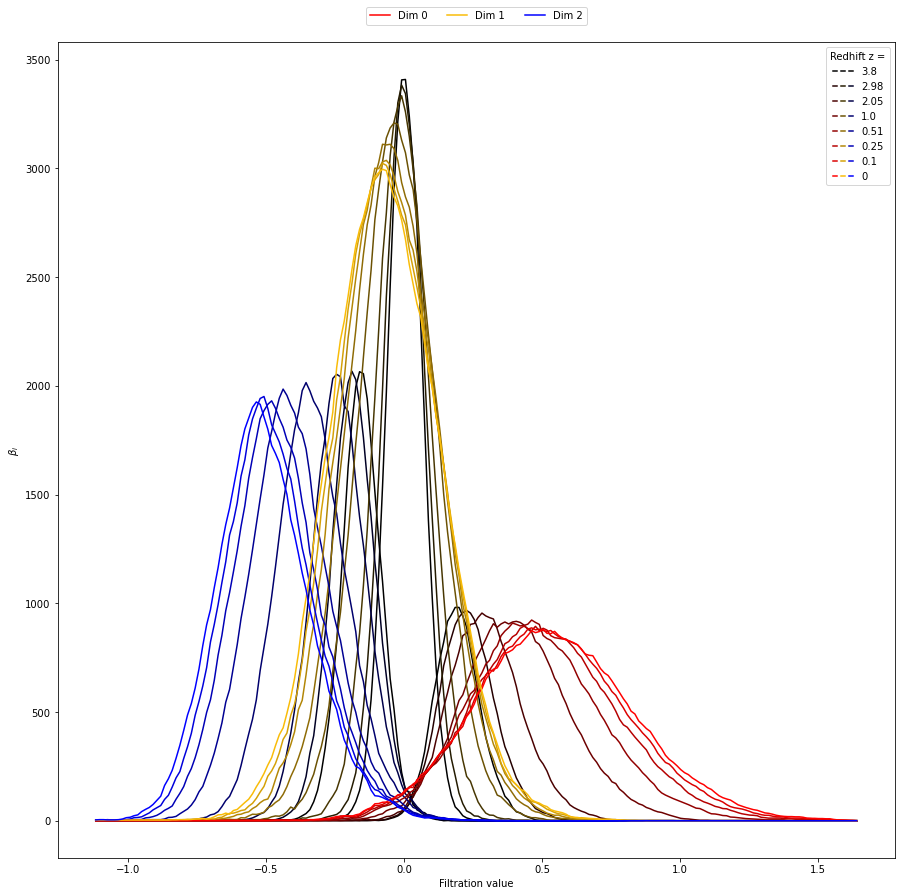

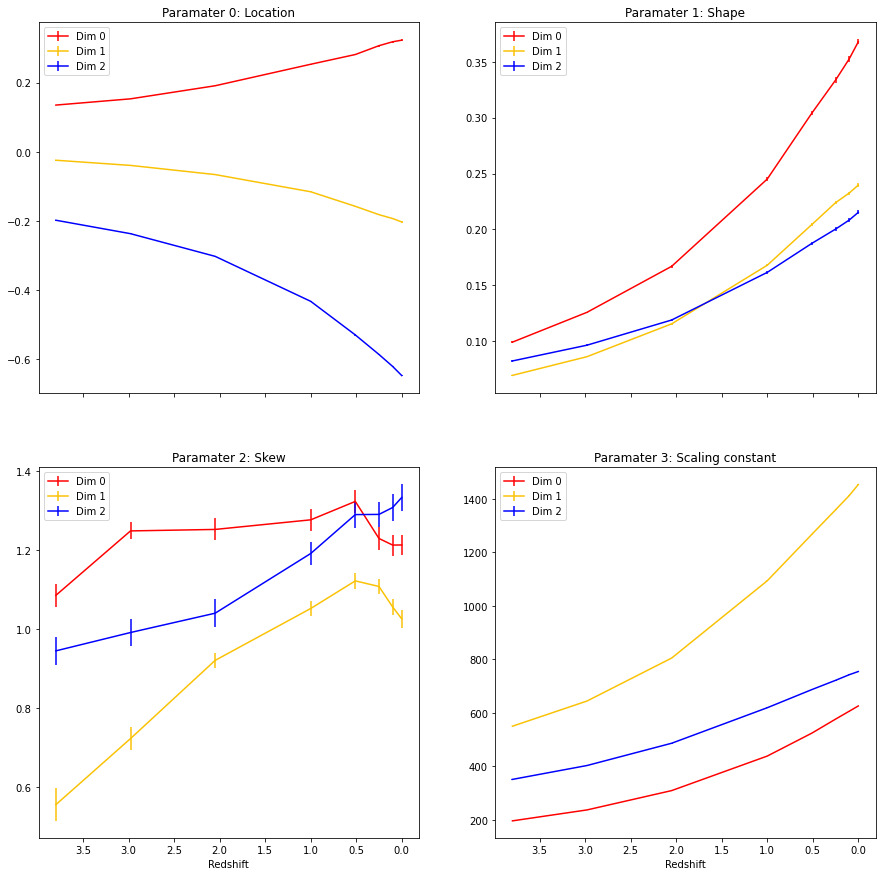

In [5]:
# Evaluate Betti curves using a skew normal distribution:
def skewnormal(x,mu,sigma,skew,scale):
    """Skew ln, uses scipy.stats: norm"""
    return 2*scale*norm.pdf((x-mu)/sigma)/sigma*norm.cdf(skew*(x-mu)/sigma)
# Parameter names (for plotting)
parameter_names = ['Location','Shape','Skew','Scaling constant']

parameters_evolution = np.zeros((8,3,4,2))
# Store as array, to allow easy comparison:
# 8 snapshots
# 3 dimensions
# 4 parameters
# each with value and error
for snap_id, b_curves in enumerate(Betti_curve_evolution):  # for each snapshot
    for dim, b_curve in enumerate(b_curves):            # for each dimension
        parameters, pcov = sc.optimize.curve_fit(skewnormal,
                                                 betti_curve_vector,
                                                 b_curve)
        perr = np.sqrt(np.diag(pcov))
        parameters_evolution[snap_id, dim, :, 0] = parameters
        parameters_evolution[snap_id, dim, :, 1] = perr


# Visualisations
# Betti curve evolution, using a colour gradient
# Dimension 0: red
# Dimension 1: gold
# Dimension 2: blue
redshift = [3.8, 2.98, 2.05, 1.00, 0.51, 0.25, 0.1, 0]
cdim_rgb = {0: np.array([255/255, 0, 0]),
            1: np.array([249/255,188/255,8/255]),
            2: np.array([0, 0, 255/255])}
fig, ax = plt.subplots(1,1,figsize=(15,15))
im_z= [[], [], [], [], [], [], [], []]
for snap_id, b_curves in enumerate(Betti_curve_evolution):  # for each snapshot
    for dim, b_curve in enumerate(b_curves):            # for each dimension
        im, = ax.plot(betti_curve_vector,
                b_curve,
                c = cdim_rgb[dim]*(snap_id/7))
        im_z[snap_id].append(im)
legend1 = plt.legend(im_z[-1], ["Dim 0", "Dim 1", "Dim 2"],
                     loc='upper center',
                     bbox_to_anchor=(0.5, 1.05),
                     ncol=3)
ax.legend([tuple(i) for i in im_z],
           redshift,
           scatterpoints=1, numpoints=1,handler_map={tuple: HandlerTuple(ndivide=None)},
           title='Redhift z =')
ax.set_xlabel('Filtration value')
ax.set_ylabel(r'$\beta_i$')
fig.gca().add_artist(legend1)
fig.savefig('Betti_curve_evolution.png',bbox_inches='tight')

# Parameter evolution
color_dict = {0: 'r', 1: 'xkcd:goldenrod', 2: 'b'}
fig, ax = plt.subplots(2,2,figsize=(15,15),sharex=True)
for p in [0,1,2,3]:
    for dim in [0,1,2]:
        ax.flat[p].errorbar(redshift,
                            parameters_evolution[:,dim,p,0],
                            yerr = parameters_evolution[:,dim,p,1],
                            c = color_dict[dim],
                            label='Dim %i'%dim
                            )
    ax.flat[p].legend()
    ax.flat[p].set_title('Paramater %i: %s'%(p,parameter_names[p]))
ax[0,0].invert_xaxis()
ax[1,0].set_xlabel('Redshift')
ax[1,1].set_xlabel('Redshift')
fig.savefig('Parameter_curve_evolution.png',bbox_inches='tight')
